ПВ202 Нехаенко Владимир.

Лабораторная работа № 1. О росте больных ковидом

Вариант 9. С ноября 2020 по февраль 2021

In [9]:
import math
from datetime import date
from itertools import product

import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
from scipy.stats import norm, stats

df = pd.read_csv('covid-data.csv', ).sort_values('date', ascending=True)
df

,date,death,deathIncrease,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCumulative,onVentilatorCurrently,positive,positiveIncrease,states,totalTestResults,totalTestResultsIncrease
419,2020-01-13,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,1,0,0
418,2020-01-14,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,0.0,0,1,0,0
417,2020-01-15,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,0.0,0,1,0,0
416,2020-01-16,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,0.0,0,1,0,0
415,2020-01-17,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,0.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2021-03-03,508665.0,2449,45214.0,9359.0,2172,45462.0,770821.0,73857281.0,267001,4260.0,3094.0,28520365.0,66836,56,357888671,1406795
3,2021-03-04,510408.0,1743,45293.0,8970.0,1530,44172.0,772351.0,74035238.0,177957,4267.0,2973.0,28585852.0,65487,56,359479655,1590984
2,2021-03-05,512629.0,2221,45373.0,8634.0,2781,42541.0,775132.0,74307155.0,271917,4275.0,2889.0,28654639.0,68787,56,361224072,1744417
1,2021-03-06,514309.0,1680,45453.0,8409.0,503,41401.0,775635.0,74450990.0,143835,4280.0,2811.0,28714654.0,60015,56,362655064,1430992


Получение данных о заболевших в день за определенный период

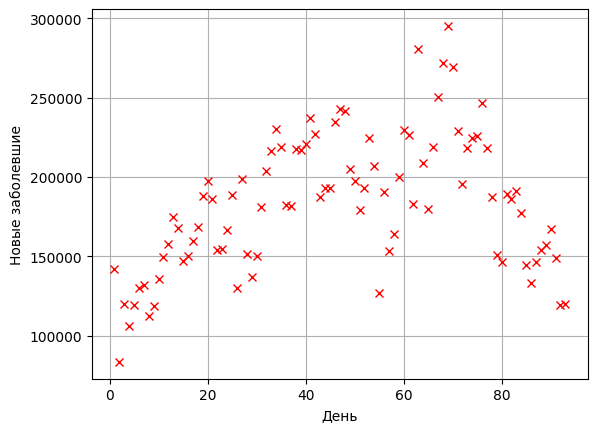

In [10]:
start_date = date(2020, 11, 1)
end_date = start_date + relativedelta(months=3)

# Фильтрация датафрейма по дате
df = df[df.apply(lambda row: start_date <= date.fromisoformat(row['date']) <= end_date, axis=1)]

x = df['positiveIncrease'].to_numpy()
t = np.array(range(1, len(x)+1))

plt.xlabel("День")
plt.ylabel("Новые заболевшие")
plt.grid()
plt.plot(t, x, "rx")

Логарифмирование данных (сведение к линейной модели), вычисление средних

In [11]:
y = np.array(list(map(math.log, x)))
ty = t * y

t_mean = t.mean()
y_mean = y.mean()
ty_mean = ty.mean()

Вычисление ковариации

In [12]:
cov = ty_mean - t_mean * y_mean

Вычисление дисперсии по t

In [13]:
t2 = t ** 2
dt = t2.mean() - t_mean ** 2

Вычисление коэффициентов регрессии

In [14]:
b = cov / dt
a = y_mean - b * t_mean
A = math.exp(a)
print(b, A)

0.0030866538277854313 154030.24281708512


График аппроксимации

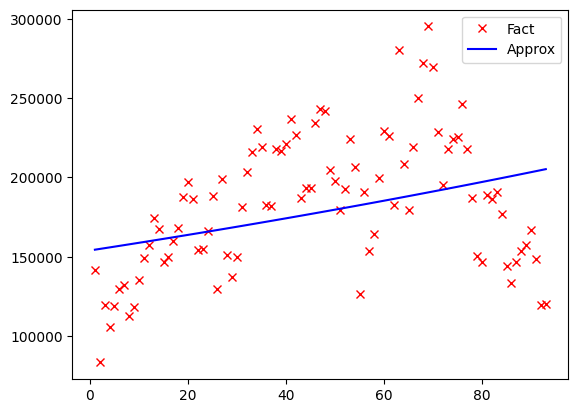

In [15]:
z = np.array(list(map(lambda ti: A * math.exp(b * ti), t)))

plt.plot(t, x, 'rx', label='Fact')
plt.plot(t, z, 'b-', label='Approx')
plt.legend()
plt.show()

Проверка гипотезы о виде распределения с помощью критерия X^2

In [16]:
eps = A * np.array(list(map(lambda ti: math.exp(b * ti), t))) - x
eps2 = eps ** 2

sigma = math.sqrt(eps2.mean() - eps.mean())

s = math.trunc(math.log2(len(x))) + 1

# Разбиение на интервалы
step = (eps.max() - eps.min()) / s
edges = [eps.min()]

for i in range(1, s + 1):
    edges.append(edges[i-1] + step)

edges[0] = -math.inf
edges.append(math.inf)

# Вычисление фактических частот
count = [0] * len(edges)

for i, j in product(range(1, len(edges)), eps):
    if edges[i-1] <= j < edges[i]:
        count[i] += 1

count.pop(0)

# Вычисление теоретических частот
p = [norm.cdf(edges[i] / sigma) - norm.cdf(edges[i-1] / sigma) for i in range(1, len(edges))]
n_t = np.array(p) * len(t)

k, p = stats.chisquare(count, n_t, ddof=1)

print('k =', k)
print('p =', p)

if p > 0.05:
    print('Гипотеза подтверждается')
else:
    print('Гипотеза не подтверждается')

k = 4.1196181625468125
p = 0.6604926118456349
Гипотеза подтверждается


C:\Users\Vovan\AppData\Local\Temp\ipykernel_12760\1824286163.py:31: DeprecationWarning: Please use `chisquare` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  k, p = stats.chisquare(count, n_t, ddof=1)
